In [1]:
# 기본 환경 로드
%run ./env.ipynb

# Fit Data Model

ETL를 통해 생성된 데이터셋을 이용하여 훈련을 통해 데이터 모델을 생성합니다.

In [2]:
from utils import *

sdate = get_env_sdate(default = "2018070108")
path_base = get_env_path_base(default = "/root/mnt/dfs/notebooks-skp/mnist")
path_data = get_env_path_date(default = "/root/mnt/dfs/data/mnist")

print("sdate: {}".format(sdate))
print("path_base: {}".format(path_base))
print("path_data: {}".format(path_data))

sdate: 2018070108
path_base: /root/mnt/dfs/notebooks-skp/mnist
path_data: /root/mnt/dfs/data/mnist


In [3]:
# 데이터 로드
import os
from sklearn.externals import joblib 

path_etl = os.path.join(path_data, "etl")
path_etl_sdate = os.path.join(path_etl, sdate)

path_train_xs = os.path.join(path_etl_sdate, "dnn-train_xs.pkl")
path_train_ys = os.path.join(path_etl_sdate, "dnn-train_ys.pkl")
np_train_xs = joblib.load(path_train_xs)
np_train_ys = joblib.load(path_train_ys)
print(np_train_xs.shape, np_train_ys.shape)

path_test_xs = os.path.join(path_etl_sdate, "dnn-test_xs.pkl")
path_test_ys = os.path.join(path_etl_sdate, "dnn-test_ys.pkl")
np_test_xs = joblib.load(path_test_xs)
np_test_ys = joblib.load(path_test_ys)
print(np_test_xs.shape, np_test_ys.shape)

(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [4]:
dim_x = np_train_xs.shape[1]
n_class = np_train_ys.shape[1]

In [5]:
# Keras: set GPU options for Tensorflow Backend
import tensorflow as tf
from keras import backend as k
 
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
sess = tf.Session(config=config)
k.tensorflow_backend.set_session(sess)

Using TensorFlow backend.


In [6]:
# 모델 로드
from fdm_model import create_dnn

model = create_dnn(n_input=dim_x, n_class=n_class)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2580      
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
__________

In [7]:
from keras import callbacks

# 훈련을 통해 제일 좋은 성능을 보인 모델만을 저장합니다.
with sess.graph.as_default():
    path_fdm = os.path.join(path_data, "fdm")
    path_fdm_sdate = os.path.join(path_fdm, sdate)
    os.makedirs(path_fdm_sdate, exist_ok=True)

    # path_model = os.path.join(path_fdm_sdate, "dnn-{epoch:02d}-{val_loss:.2f}.hdf5")
    path_model = os.path.join(path_fdm_sdate, "dnn-best.hdf5")

    epochs = 10
    batch_size = 100
    checkpoint = callbacks.ModelCheckpoint(path_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    earlystop = callbacks.EarlyStopping(monitor='val_acc', patience=int(epochs * 0.3), mode='auto')
    callbacks_list = [checkpoint, earlystop]

    history = model.fit(np_train_xs, np_train_ys, batch_size=batch_size, epochs=epochs, verbose=2, callbacks=callbacks_list, validation_split=0.3, shuffle=True)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
 - 1s - loss: 0.9575 - acc: 0.6631 - val_loss: 0.2129 - val_acc: 0.9434

Epoch 00001: val_acc improved from -inf to 0.94339, saving model to /root/mnt/dfs/data/mnist/fdm/2018070108/dnn-best.hdf5
Epoch 2/10
 - 1s - loss: 0.5025 - acc: 0.8228 - val_loss: 0.1674 - val_acc: 0.9555

Epoch 00002: val_acc improved from 0.94339 to 0.95550, saving model to /root/mnt/dfs/data/mnist/fdm/2018070108/dnn-best.hdf5
Epoch 3/10
 - 1s - loss: 0.4134 - acc: 0.8488 - val_loss: 0.1384 - val_acc: 0.9633

Epoch 00003: val_acc improved from 0.95550 to 0.96328, saving model to /root/mnt/dfs/data/mnist/fdm/2018070108/dnn-best.hdf5
Epoch 4/10
 - 1s - loss: 0.3646 - acc: 0.8599 - val_loss: 0.1404 - val_acc: 0.9654

Epoch 00004: val_acc improved from 0.96328 to 0.96544, saving model to /root/mnt/dfs/data/mnist/fdm/2018070108/dnn-best.hdf5
Epoch 5/10
 - 1s - loss: 0.3324 - acc: 0.8708 - val_loss: 0.1352 - val_acc: 0.9662

Epoch 00005: val_acc improved fro

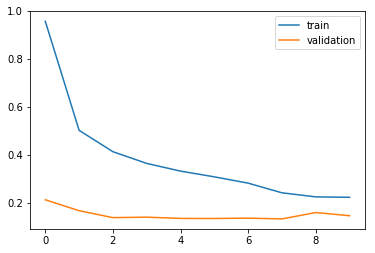

In [8]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [9]:
# 가중치 로드
from keras import callbacks

path_fdm = os.path.join(path_data, "fdm")
path_fdm_sdate = os.path.join(path_fdm, sdate)

# path_model = os.path.join(path_fdm_sdate, "dnn-{epoch:02d}-{val_loss:.2f}.hdf5")
path_model = os.path.join(path_fdm_sdate, "dnn-best.hdf5")

model.load_weights(path_model)

In [10]:
with sess.graph.as_default():
    np_pred_ys = model.predict(np_test_xs)
    print(np_pred_ys.shape)

(10000, 10)


In [11]:
from sklearn import metrics 
from sklearn.metrics import classification_report

np_pred_ys = model.predict_classes(np_test_xs)
np_real_ys = np.argmax(np_test_ys, axis=1)

print("\n")
print(classification_report(np_real_ys, np_pred_ys))



             precision    recall  f1-score   support

          0       0.98      0.99      0.98       980
          1       0.99      0.98      0.99      1135
          2       0.98      0.97      0.98      1032
          3       0.96      0.98      0.97      1010
          4       0.98      0.97      0.98       982
          5       0.99      0.96      0.97       892
          6       0.98      0.98      0.98       958
          7       0.98      0.97      0.98      1028
          8       0.94      0.97      0.96       974
          9       0.98      0.97      0.97      1009

avg / total       0.98      0.98      0.98     10000

